# Programming Application: Land Tenure Security

### Perceived land tenure insecurity manifested in physical environment

##### This session is designed for supporting the technical components of the course ***Planning Sustainable Cities (2020-1B)***, Department of Urban and Regional Planning and Geo-Information Management, Faculty Geo-Information Science and Earth Observation, University of Twente, Netherlands. Should you find the details of the course at https://canvas.utwente.nl/courses/6184.

##### Dr. Jiong (Jon) Wang,  j.wang-4@utwente.nl


## Foreword
-------------------
Fast urbanization in many developing countries, especially for those at the *Global South*, is forcing a large urban population to live in deprived areas due to the failure in providing basic living necessities. These deprived areas are also known as slums or informal settlements, which are characterized by poor housing, overcrowded neighborhoods, insufficient sanitation and limited land tenure security. Insecure land tenure could be the worst senario of deprivation that people lose their land properties. And the insecurity is largely reflected by people's feeling about the likelihood of losing their land property due to persisting threats of eviction of the settlements.

Addressing land tenure insecurity, especially for the poor and the vulnerable groups, was identified as one of the essential steps towards sustainable development as highlighted in goal 1, target 1.4 and 11 of Sustainable Development Goals (SDGs), aimed at increasing tenure security for all and making safe and inclusive cities and human settlements (United Nations, 2015). In order to acquire timely and complete overview of how urban residents perceive the insecurity of their land property, capturing perceived land tenure insecurity is naturally linked to the power of earth observation (EO) based technology along with other geospatial datasets.

Given the fact that EO based technology has already been applied in reliable manners in monitoring urban deprivation, in 2020, our former MSc student Mr. Jesse Esaie Dufitimana initiated his research on capturing perceived tenure insecurity from the geospatial perspective. He started with a very detailed survey in Kigali, Rwanda, regarding the perceived land tenure insecurity, along with the observed physical environment by all the interview participants. He then conducted systematic comparison between the observed physical environment and the perceived tenure insecurity obtained from the survey, and tried to relate such surveyed information further to that captured and derived from remote sensing imagery data. One of the key findings from Jesse's study is that: by only using freely available Google Earth images, it is possible to capture 40-60% of information about the perceived land tenure insecurity. This preliminary yet important investigation opens the door for further exploration of how remote sensing data can be used to capture perceived land tenure insecurity.

In this session, you're going to follow the rationale adopted in Jesse's research, and implement a mini version of the same research. You will be using the survey data provided by Jesse, and try to explore another set of remote sensing imagery data from Sentinel-2, and try to understand how information on Sentinel-2 images reflects the perceived land tenure insecurity recorded from the survey in the form of GIS point dataset. Your research will be following:

- 0. What do we have: Loading data.
- 1. How the data looks like: Visual inspection
- 2. Information extraction: Deriving indicators at surveyed locations
- 3. Relating information: Indicators and perceived land tenure insecurity
- 4. Final challenge: refine and repeat the experiment


##### Credit
-------------------
You're very welcome to use the content of this page for teaching and learning. Credit to this work can be given as:
~~~
J. Wang, Programming Application: Land Tenure Security (2021), GitHub repository,
https://github.com/wonjohn/Bayes_for_Regression
~~~

### 0. What do we have: Loading data

##### 0.1 The survey from a *.shp file, loaded as Geopandas dataframe.

In [2]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
#% pip install geopandas
import geopandas as gpd
#% pip install rasterio
import rasterio
from rasterio.plot import show
from sklearn import cluster

# Load the survey data in GIS point format.
# The original *.shp file of the survey is loaded by using the Geopandas module, and loaded as a Geopandas dataframe
# The frame is still a table as you will see.
survey = gpd.read_file('data/landadmin/Survey_data.shp')

# Load the basemap as a visual reference
# The basemap is loaded as a Rasterio object
file_location = 'data/landadmin/kigali_basemap.tif'
basemap = rasterio.open(file_location, nodata=0)

In [3]:
# A quick look into the survey data

# Loaded as a Geopandas dataframe, the survey can be visualized by calling the internal/built-in function .head()
survey.head()  # See only the first few lines

# !!!! Important, when you load your *.shp file by using Geopandas, the coordinates are attached to the last columns.!!!!
# Here, you also see in the first two columns of the table recording the orginal coordinates in from ESRI ArcGIS.
# Without reprojection, the Geopandas will show coordinates same as the original ones.

,POINT_X,POINT_Y,Unpaved_ro,Unpaved_fo,Electricit,Public_wat,Wastes,Green_spac,Open_space,Dominant_b,...,Occ_future,Doc_type,Eviction_e,Reasons,Prop_loss_,Causes,Others_Cau,Event_loss,Protection,geometry
0,505651.543142,4.785076e+06,Yes,Yes,Yes,No,No,No,Yes,Small,...,Between 5 and 10 years,Lease agreement,Yes,Urban (re)development/ masterplan,Very likely,Urban (re)development/ masterplan,None,Land readjustment,Fairly strongly,POINT (505651.543 4785076.481)
1,505623.114410,4.785109e+06,Yes,Yes,Yes,No,No,No,Yes,Small,...,Between 5 and 10 years,Sale agreement,No,None,Very likely,Urban (re)development/ masterplan,None,Land readjustment,Fairly strongly,POINT (505623.114 4785109.344)
2,505585.721795,4.785038e+06,Yes,Yes,Yes,Yes,No,No,No,Small,...,Less than 1 year,Lease agreement,No,None,Somewhat likely,Urban (re)development/ masterplan,None,Land readjustment,Fairly strongly,POINT (505585.722 4785037.786)
3,505583.247006,4.784939e+06,Yes,Yes,Yes,Yes,No,No,No,Small,...,Between 5 and 10 years,Lease agreement,Yes,For access to infrastructure,Very likely,Steep slop,Urban (re)development/ masterplan,Land readjustment,Neutral,POINT (505583.247 4784939.199)
4,505518.972571,4.784957e+06,Yes,Yes,Yes,Yes,No,No,Yes,Small,...,Between 5 and 10 years,Lease agreement,No,None,Very likely,Steep slop,Expropriation,Fair compensation,Fairly strongly,POINT (505518.973 4784957.014)


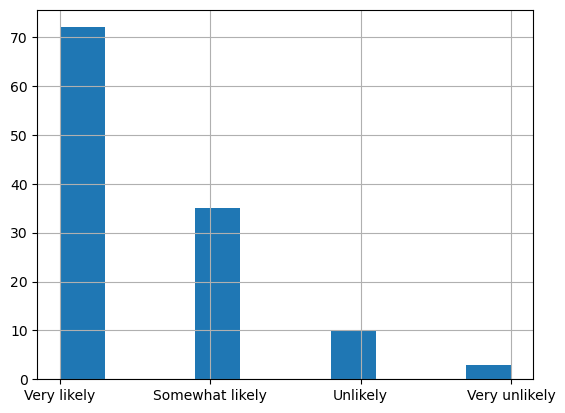

In [4]:
# We can further call other built-in functions to visualize some basic statistics

survey['Prop_loss_'].hist()
plt.show()

# What kind of information do you see in the figure below?

##### 0.2 The Sentinel-2 bands loaded as Rasterio objects, and then array data extracted read from the objects.

In [5]:
# Load individually the 4 Sentinel-2 bands
# Again, we use the Rasterio to load all Sentinel-2 bands available
# Try to figure out what do the following lines of codes mean?

file_location = 'data/landadmin/kig_sb2.tif'
b2_reader = rasterio.open(file_location, nodata=0)
b2 = b2_reader.read(1)

file_location = 'data/landadmin/kig_sb3.tif'
b3_reader = rasterio.open(file_location, nodata=0)
b3 = b3_reader.read(1)

file_location = 'data/landadmin/kig_sb4.tif'
b4_reader = rasterio.open(file_location, nodata=0)
b4 = b4_reader.read(1)

file_location = 'data/landadmin/kig_sb8.tif'
b8_reader = rasterio.open(file_location, nodata=0)
b8 = b8_reader.read(1)

### 1. How the data looks like: Visual inspection.

##### 1.1 The survey data visualized against the basemap

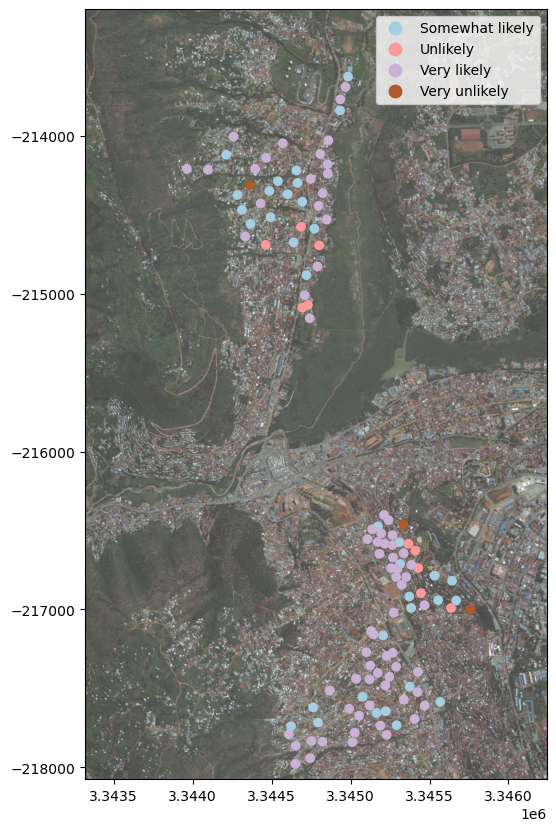

In [6]:
# Visualize the data by overlaying the survey points upon the basemap

# But before overlaying, we need to ensure the projection systems are consistent.
# Please figure out what does the following line of code mean?
survey = survey.to_crs(basemap.crs)

# Plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
show(basemap, ax=ax, alpha=0.8)
survey.plot(column='Prop_loss_', legend=True, ax=ax, cmap='Paired')
plt.show()

##### 1.2 The survey data visualized against the Sentinel-2 bands

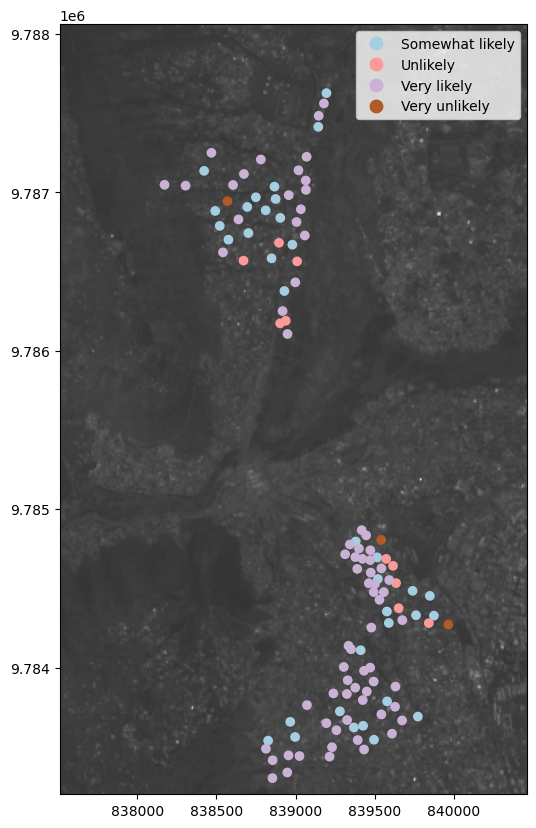

In [7]:
# Now try to load the Sentinel-2 TIFF into the interface for further visual inspection

# Please figure out what does the following line of code mean?
survey = survey.to_crs(b2_reader.crs)

# Plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
show(b2_reader, cmap='gray', ax=ax, alpha=0.8)
survey.plot(column='Prop_loss_', legend=True, ax=ax, cmap='Paired')
plt.show()

In [8]:
# Please also take a look at the projection systems in both the survey GIS points and Sentinel-2

'''
# Answers and hints

Your code: file_name.crs...

'''

'\n# Answers and hints\n\nYour code: file_name.crs...\n\n'

##### 1.3 Basic statistics of the Sentinel-2 bands

In [9]:
# Recall how you created basic stats regarding imagery data? Histogram?
# Try to inspect the distributions values in all loaded Sentinel-2 data by using histograms

'''
# Answers and hints

# Be careful with the data range for creating a meaningful histogram. Then how to inspect the data range?

Your code:

my_bin = list(np.arange(start=,stop=,step=))
plt.hist(b2.ravel(), bins = my_bin)  # What does the '.ravel()' mean here?
plt.title("histogram") 
plt.show()

'''

'\n# Answers and hints\n\n# Be careful with the data range for creating a meaningful histogram. Then how to inspect the data range?\n\nYour code:\n\nmy_bin = list(np.arange(start=,stop=,step=))\nplt.hist(b2.ravel(), bins = my_bin)  # What does the \'.ravel()\' mean here?\nplt.title("histogram") \nplt.show()\n\n'

In [10]:
# Programming can be handy for creating multiple similar visualization, it automatically repeat same plotting procedure for you.
# Try to repeatedly create histograms for all 4 Sentinel bands by using the FOR loop
# Please note to choose a proper data range for all the histograms

# First all the bands are stored in a list for looping over
b = [b2, b3, b4, b8]

'''
# Answers and hints

# Try to figure out how the following codes work and fill out the empty places
fig = plt.figure()
for ind in range(4):
    plt.subplot(2, 2, ind+1)
    my_bin = list(np.arange(start= ,stop= ,step= ))
    plt.hist(b[ind].ravel(), bins = my_bin)  # What does the '.ravel()' mean here?
    plt.title(str(ind)) 

plt.show()

# Ultimately, do the values and figures make sense?

'''

"\n# Answers and hints\n\n# Try to figure out how the following codes work and fill out the empty places\nfig = plt.figure()\nfor ind in range(4):\n    plt.subplot(2, 2, ind+1)\n    my_bin = list(np.arange(start= ,stop= ,step= ))\n    plt.hist(b[ind].ravel(), bins = my_bin)  # What does the '.ravel()' mean here?\n    plt.title(str(ind)) \n\nplt.show()\n\n# Ultimately, do the values and figures make sense?\n\n"

In [11]:
# If you would like to make the values more meaningful as reflectance, you need to apply a rescale factor
# Try to recall and experiment with rescaling the band values
# Try to search and refer to online documentations regarding the Sentinel-2 scale factor

'''
# Answers and hints

Would be something like: new_b2 = old_b2*factor

'''

'\n# Answers and hints\n\nWould be something like: new_b2 = old_b2*factor\n\n'

### 2. Information extraction: Deriving indicators at surveyed locations
##### Now, does the imagery data reflect the information in the survey? That is to say, We would like to see, at each of the surveyed point, if the survey data is related to the spectral information on the images.
##### In order to see if the spectral information is related to the survey data, we can start to look at the pixels around each surveyed points.

##### 2.1 Double check the consistency between the survey data and Sentinel-2 imagery data

In [12]:
# But before looking into the pixels and points, we need to confirm that the two datasets (GIS points and imagery data) are with same coordinates.
# Remember we have already changed the CRS of the survey point data into the one of the Sentinel-2 data.
# Let's simply check if the survey coordinates fall into the bound of the Sentinel-2 images

# We can just check few survey points. What does this following line mean?
survey.loc[survey['Prop_loss_'] == 'Very unlikely']

,POINT_X,POINT_Y,Unpaved_ro,Unpaved_fo,Electricit,Public_wat,Wastes,Green_spac,Open_space,Dominant_b,...,Occ_future,Doc_type,Eviction_e,Reasons,Prop_loss_,Causes,Others_Cau,Event_loss,Protection,geometry
24,505746.717737,4.785048e+06,Yes,Yes,Yes,Yes,Yes,No,Yes,Medium,...,Longer than 10 Years/lifelong,Lease agreement,Yes,For access to infrastructure,Very unlikely,None,None,Land readjustment,Fairly strongly,POINT (839540.291 9784805.515)
33,506170.666257,4.784515e+06,Yes,Yes,Yes,No,No,Yes,Yes,Medium,...,Longer than 10 Years/lifelong,Lease agreement,Yes,For access to infrastructure,Very unlikely,None,None,Upgrading,Fairly strongly,POINT (839963.768 9784271.593)
107,504773.380090,4.787182e+06,Yes,Yes,Yes,No,No,No,Yes,Medium,...,Longer than 10 Years/lifelong,Lease agreement,Yes,For access to infrastructure,Very unlikely,None,None,Land readjustment,Fairly strongly,POINT (838569.641 9786943.555)


In [13]:
# What are the reprojected CRS of the survey points above?

# Now let's see the bounding box of the Sentinel-2, band 2 image
b2_reader.bounds

# Do the points fall into the bound of the Sentinel-2?

BoundingBox(left=837510.0, bottom=9783200.0, right=840460.0, top=9788060.0)

In [14]:
# Once we ensured the survey points in the *.shp file fall into the bounds of the imagery data,
# We can further confirm if the survey points are located on the image as we visualized above,
# as it is always safe to check computationally rather than only visualizing

# What we can do is to see if the coordinates, once transformed into the row and column index of the image, still fall into the extent of the image

# Now pick one of the point in the survey data, use its coordinates, and transform it into row and column index
# The rasterio provides a function to do this, and please figure out how the following codes work?
xs, ys = 839540.291, 9784805.515
rows, cols = rasterio.transform.rowcol(b2_reader.transform, xs, ys)

# Print the row and column index of the survey point, and the extent/shape of the image, do they make sense to you?
print('The rows and columns of the survey point is: ' + str((rows, cols)))
print('And the shape of the image in pixels is ' + str(b2_reader.shape))

The rows and columns of the survey point is: (325, 203)
And the shape of the image in pixels is (486, 295)


##### 2.2 Simple spectral statistics around survey points

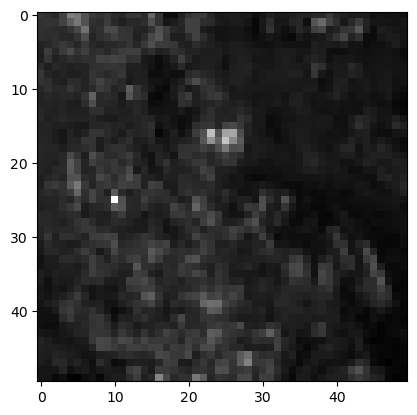

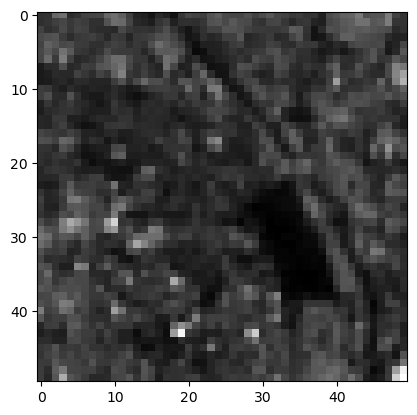

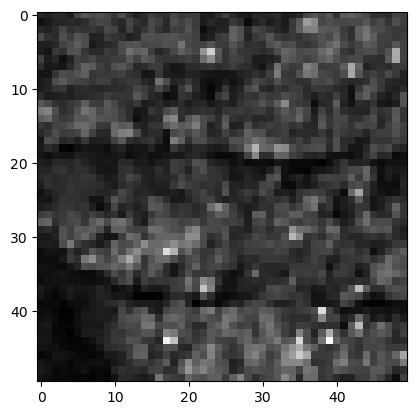

In [15]:
# Then we can extract some spectral information around each survey point
# We can still start simple, for instance, to extract a small image patch around a survey point
# In the above example, we have printed out the only 3 points were survey participants indicated "Very unlikely" to lose their property
# Let's extract the small image patch around these 3 points

# What does the following line of code mean?
survey_unlikely = survey.loc[survey['Prop_loss_'] == 'Very unlikely']

# Here, we start to draw the small patches around each survey point with "Very unlikely" probability to lose land property
# We arbitrarily extract image patches by a window size of 51 pixels around each point,
# thus it is 25 pixels from the point to the window edge

win_half = 25  # Half of the window size
for ind, row in survey_unlikely.iterrows():  # Looping over all points
    rows, cols = rasterio.transform.rowcol(b2_reader.transform, row['geometry'].x, row['geometry'].y)
    plt.imshow(b2[rows-win_half:rows+win_half, cols-win_half:cols+win_half], cmap='gray')
    plt.show()

In [16]:
# Let's say the simpliest indicator is the average pixel values around each survey point
# It's your turn to print the average band 2 pixel values around the points with "Very unlikely"

'''
# Answers and hints

win_half = 25  # Half of the window size
for :  # Looping over all points
    # Use something like: b2[rows-win_half:rows+win_half, cols-win_half:cols+win_half].mean()
    
'''

'\n# Answers and hints\n\nwin_half = 25  # Half of the window size\nfor :  # Looping over all points\n    # Use something like: b2[rows-win_half:rows+win_half, cols-win_half:cols+win_half].mean()\n    \n'

##### 2.3 More meaningful statistics of land specifications around survey points

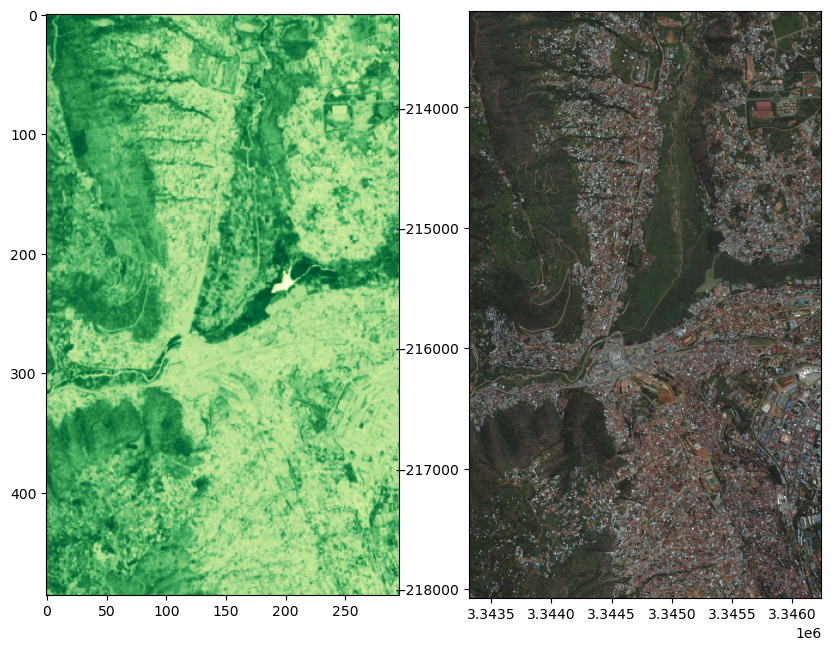

<AxesSubplot:>

In [17]:
# A more interesting indicator can be, again, NDVI, because it is direclty linked to a common land surface specification
# Please repeat the above procedure to print the average NDVI around each point with "Very unlikely"

# For Sentinel-2 data, the NDVI can be obtained through
ndvi = (b8*0.00001-b4*0.00001)/(b8*0.00001+b4*0.00001)

# Compared with the basemap of the Google Earth image
plt.figure(figsize = (10,10))
plt.subplot(1, 2, 1)
plt.imshow(ndvi, cmap='YlGn')
plt.subplot(1, 2, 2)
show(basemap)

In [18]:
# Now, looping through the few points we saw above, and show the NDVI image patch around each point

'''
# Answers and hints

win_half = 25  # Half of the window size
for :  # Looping over all points
    # Use something like: ndvi[rows-win_half:rows+win_half, cols-win_half:cols+win_half].mean()
    
'''

'\n# Answers and hints\n\nwin_half = 25  # Half of the window size\nfor :  # Looping over all points\n    # Use something like: ndvi[rows-win_half:rows+win_half, cols-win_half:cols+win_half].mean()\n    \n'

In [19]:
# For further analysis, we would like to store the computed indicator, for instance the average NDVI for each point.
# To do so, we can introduce an empty list to store the computed average NDVI around each point
# This time, we loop over all survey points in the *.shp file

ndvi_all = []  # Empty list
win_half = 25  # Half of the window size
for ind, row in survey.iterrows():  # Looping over all points
    rows, cols = rasterio.transform.rowcol(b2_reader.transform, row['geometry'].x, row['geometry'].y)
    ndvi_all.append(ndvi[rows-win_half:rows+win_half, cols-win_half:cols+win_half].mean())
    
print(ndvi_all)  # Always try to print and see your results

[0.15641346521269475, 0.14703979972106235, 0.14174021073137538, 0.13081300877060667, 0.12535811692112453, 0.13534276749637691, 0.14427756100735314, 0.14594853263227775, 0.17030811819797956, 0.17457354970606154, 0.12417025280135283, 0.1499281716284204, 0.15957412128040363, 0.17976768099855725, 0.1616880082946477, 0.1521438222224989, 0.1427470293493906, 0.17053365285854283, 0.1540346861625001, 0.1621966267285423, 0.1711675695010896, 0.16548720874466685, 0.18308840251590935, 0.19588658714650542, 0.19399138358175663, 0.208418643742734, 0.20617683480427923, 0.1871577658147981, 0.19577817658898974, 0.21797141415900514, 0.22612879902017594, 0.20312462085468092, 0.20503563847745518, 0.1832297616155497, 0.20545087386764163, 0.12874510629917724, 0.15359582352010223, 0.1491197669276372, 0.22790604611198292, 0.23846264757514227, 0.17889717177612238, 0.22573147209636377, 0.23295189174464018, 0.12729839233837512, 0.1279159991617766, 0.15367259883003156, 0.12656268262579715, 0.12921435580292534, 0.19

In [20]:
# Check if the length of the computed indicators equals to the survey size
len(ndvi_all) == len(survey)

True

### 3. Relating information: Indicators and perceived land tenure insecurity

##### 3.1 Simple visualization of NDVI and survey through scatter plots

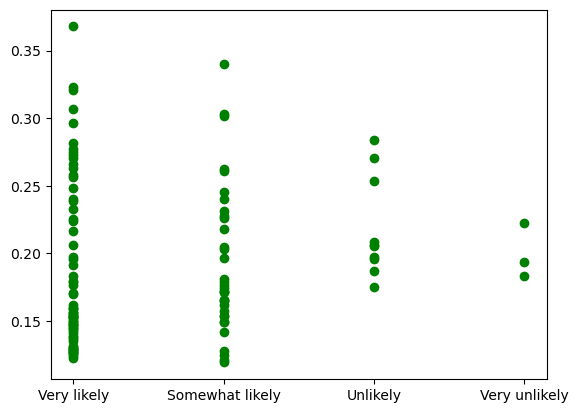

In [21]:
# As long as we have obtained perceived tenure insecurity and a corresponding column of indicator values, e.g. the NDVI,
# we can start to look at these two columns of information, that is perceived tenure insecurity vs. NDVI


# The most straightforward way is to extract the column of relevant information from the survey file,
# and plot it together with the NDVI value as scatter plot.
# Try to understand how the following line of code works.
plt.plot(survey['Prop_loss_'].values, ndvi_all, 'go', label='point-wise plot')
plt.show()

# Does the result make sense to you?

##### 3.2 More meaningful statistics between NDVI and survey points.

In [22]:
# A more handy way to visualize the relationship between the NDVI and the survey data is to 
# take advantage of the built-in plotting functionality of the Geopandas dataframe.

# To use the Geopandas internal plotting functionality, we need to first integrate the NDVI into the survey file
# Try to figure out what the following lines of codes mean.
survey['green']=ndvi_all
survey.head()

,POINT_X,POINT_Y,Unpaved_ro,Unpaved_fo,Electricit,Public_wat,Wastes,Green_spac,Open_space,Dominant_b,...,Doc_type,Eviction_e,Reasons,Prop_loss_,Causes,Others_Cau,Event_loss,Protection,geometry,green
0,505651.543142,4.785076e+06,Yes,Yes,Yes,No,No,No,Yes,Small,...,Lease agreement,Yes,Urban (re)development/ masterplan,Very likely,Urban (re)development/ masterplan,None,Land readjustment,Fairly strongly,POINT (839445.060 9784834.282),0.156413
1,505623.114410,4.785109e+06,Yes,Yes,Yes,No,No,No,Yes,Small,...,Sale agreement,No,None,Very likely,Urban (re)development/ masterplan,None,Land readjustment,Fairly strongly,POINT (839416.658 9784867.233),0.147040
2,505585.721795,4.785038e+06,Yes,Yes,Yes,Yes,No,No,No,Small,...,Lease agreement,No,None,Somewhat likely,Urban (re)development/ masterplan,None,Land readjustment,Fairly strongly,POINT (839379.096 9784795.660),0.141740
3,505583.247006,4.784939e+06,Yes,Yes,Yes,Yes,No,No,No,Small,...,Lease agreement,Yes,For access to infrastructure,Very likely,Steep slop,Urban (re)development/ masterplan,Land readjustment,Neutral,POINT (839376.443 9784696.967),0.130813
4,505518.972571,4.784957e+06,Yes,Yes,Yes,Yes,No,No,Yes,Small,...,Lease agreement,No,None,Very likely,Steep slop,Expropriation,Fair compensation,Fairly strongly,POINT (839312.128 9784714.917),0.125358


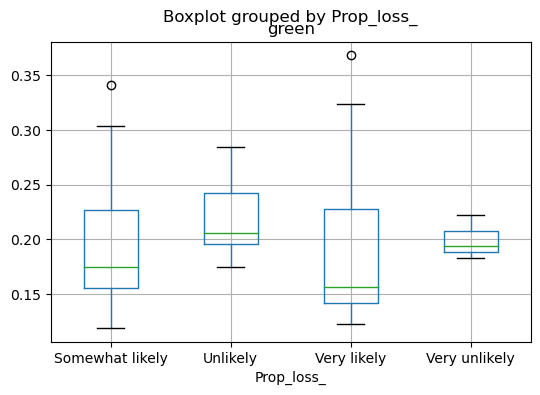

In [24]:
# Now we can create boxplot, which is a more meaningful statistics than pure scatter plots, by using Geopandas built-in function.

fig, ax = plt.subplots(figsize=(6,4))
survey.boxplot(column='green', by='Prop_loss_', ax=ax) 
plt.show()

##### 3.3 Exercise 1: Does the NDVI computed from the Sentinel-2 capture the perception in the survey?

Apart from the surveyed perceived probability of losing land properties, there is also another column in the survey file showing the observed green space ('Green_spac'). It could be interesting to see if this observation on the ground is reflected also on the Sentinel-2 imagery data. This is also important as to know if satellite imagery data can not only capture overall perception of land tenure insecurity, but also some physical specifications about the environment observed on the ground.

In [27]:
# Again, please use the built-in boxplot function of the Geopandas for visualization.

'''
# Answers and hints

#Your code here: please use the column in the file named 'Green_spac'
    
'''

# Any other interesting columns in the survey worth looking at?

"\n# Answers and hints\n\n#Your code here: please use the column in the file named 'Green_spac'\n    \n"

##### 3.4 Exercise: Deriving additional indicators regarding the NDVI

Average NDVI value around each survey point is useful but not enough. You are always encouraged to experiment with more descriptors for any land surface specification. What else descriptors do you have already in your mind? Please feel free to implement your own ideas -- you will never restrict yourself in programming.

In [ ]:
# How about starting with the fraction of vegetation cover around each survey point?

'''
# Answers and hints:

# If you need vegetation cover fractions, you may want to first classify the NDVI image into vegetated and non-vegetated first.
# Then you need to follow the steps you learned above to extract an image patch from the classified vegetation image around each survey point.
# How do you compute the fraction of vegetation coverage within a patch? Think about it, and discuss with your classmates.
    
'''

### 4. Final challenge: refine and repeat the experiment

As you already walked through, with few lines of codes involving basic tricks such as to *loop over* all the survey points, you could be able to have some meaningful results for all the 120 survey points. Although very basic, it already shows the flexibility of programming for generating a repeatable and transparent workflow that can be apply to similar analysis in the future.

You can of course fine-tune and extend the existing workflow through playing with the parameters, such as the window size for extracting the image patches, or deriving more indicators other those decriptors of the NDVI. In this section, you are encouraged to develop **a full-fledged program, starting from loading data, all the way to obtain an indicator (or set of indicators) that you think is useful to capture the perceived land tenure insecurity.** The indicator can be related to descriptors of NDVI again, or other image features.

There is no requirement for the result of this challenge, but simply show your codes and boxplot(s) which you think the results are satisfying.

In [ ]:
# Producing a meaningful program requires trial-and-error, which means the exisiting codes above is already a good starting point to refine.
# There are already potential parameters that you can adjust.
# What are the parameters you would like to work with? Window size for image patch extraction? Or, vegetation cover classification?

'''
# Answers and hints

# You may want to first put all pieces together, and start to fine-tune the parameters.

'''

In [ ]:
# Other indicators? You are of course not restricted to those related to NDVI.
# How about more abstract image features?

'''
# Answers and hints

# There are a large amount of tools to generate image features, which have been very useful to leverage information from images.
# Many remote sensing applications rely on image features to train classification models and obtain land surface classifications.

# Take a look at this short video for inspirations: How to generate features in Python for machine learning? (https://www.youtube.com/watch?v=yUATC9tt7OM)